# Library

In [ ]:
pip install selectivesearch

In [ ]:
# Librerie per l'ottimizzazione e la gestione delle dipendenze
import selectivesearch

In [1]:
# Librerie standard
import os
import random
import time
import re
from pathlib import Path
from collections import defaultdict, Counter
from itertools import islice

# Librerie per il trattamento delle immagini
import cv2
import imageio.v3 as imageio
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from torchvision.transforms import functional as TF

# Librerie per il machine learning e deep learning
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as func
import torchvision.models as models
from sklearn.svm import SVC

# Librerie per la gestione dei dati
import pandas as pd
import json
import orjson
import shutil 

# Librerie per il parallelismo e il multiprocessing
import concurrent.futures
from concurrent.futures import ProcessPoolExecutor

# Librerie per il progresso e il monitoraggio
from tqdm import tqdm

# Librerie per la gestione dei dataset
from torch.utils.data import Dataset, DataLoader

# Librerie per modelli e trasformazioni in PyTorch
from torchvision import transforms

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import torchvision
from torch.optim.lr_scheduler import ReduceLROnPlateau

import matplotlib.patches as patches
import torch.nn.utils as utils
import ast
import itertools

# Path

In [2]:
#Output folders and file names
COCO_JSON_NM = 'COCO_annotations_new.json'
OUT_COCO_JSON_NM = 'mod_COCO_annotations.json'
OUT_IMAGE_FLDR_NM = 'images'
RANDOM_SEED = 2023

in_dataset_pth = Path('/kaggle/input/our-xview-dataset')
prop_dataset_pth = Path('/kaggle/input/proposals-xview-dataset-r-cnn')
actreg_dataset_pth = Path('/kaggle/input/activeregion-xviewdataset')
resnet_pth = Path('/kaggle/input/resnet-50-xview/pytorch/default')
regbox_dataset_pth = Path('/kaggle/input/regbboxdataset-xview')
out_dataset_pth = Path('/kaggle/working/')
img_fldr = Path(f'/kaggle/input/our-xview-dataset/{OUT_IMAGE_FLDR_NM}')

coco_json_pth = in_dataset_pth / COCO_JSON_NM
new_coco_json_pth = out_dataset_pth / OUT_COCO_JSON_NM
in_new_coco_json_pth = prop_dataset_pth / OUT_COCO_JSON_NM

# PROPOSALS
PROP_COCO_JSON_NM = 'proposals.json'
proposals_json = prop_dataset_pth / PROP_COCO_JSON_NM
out_proposals_json = out_dataset_pth / PROP_COCO_JSON_NM
PROPOSALS = 'proposals'
prop_fldr = out_dataset_pth / PROPOSALS


# ACTIVE REGIONS
ACTPROP_COCO_JSON_NM ='active_regions.json'
actproposals_json = out_dataset_pth / ACTPROP_COCO_JSON_NM
in_actproposals_json = actreg_dataset_pth / ACTPROP_COCO_JSON_NM
out_act_reg_folder = out_dataset_pth / PROPOSALS
act_reg_folder = actreg_dataset_pth / PROPOSALS

#DATASET
train_path = out_dataset_pth / 'train.json'
test_path = out_dataset_pth / 'test.json'
val_path = out_dataset_pth / 'val.json'
reg_path = out_dataset_pth / 'reg.json'

# Percorso per salvare il modello
path_min_loss = '/kaggle/working/ResNet50.pth'

train_features_path = out_dataset_pth / 'train_features.npy'

resnet_min_loss_path =  resnet_pth / '3/ResNet50.pth'

in_train_path = regbox_dataset_pth / 'train.json'
in_reg_path = regbox_dataset_pth / 'reg.json'
in_train_features_path = regbox_dataset_pth / 'train_features.npy'

out_reg_path = out_dataset_pth / 'new_reg.json'

random.seed(RANDOM_SEED)

In [ ]:
# Pulizia dell'output per cartelle specifiche
def clean_output(output_dir):
    if output_dir.exists() and output_dir.is_dir():
        for item in output_dir.iterdir():
            if item.is_dir():
                shutil.rmtree(item)  # Rimuove la sotto-cartella
            else:
                item.unlink()  # Rimuove il file
        print(f"Cartella {output_dir} pulita.")
    else:
        print(f"Cartella {output_dir} non trovata. Nessuna azione necessaria.")

# Pulisce la cartella di output prima di avviare il processo
clean_output(out_dataset_pth)

# Utility

In [3]:
import warnings

# Sopprime i warning specifici del modulo skimage
warnings.filterwarnings("ignore", 
    message="Applying `local_binary_pattern` to floating-point images may give unexpected results.*")

# Sopprime i warning relativi al parametro 'pretrained' deprecato
warnings.filterwarnings("ignore", 
    message="The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.")

# Sopprime i warning relativi agli argomenti diversi da weight enum o None
warnings.filterwarnings("ignore", 
    message="Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future.*")

# Sopprime i warning relativi al parametro 'verbose' deprecato
warnings.filterwarnings("ignore", 
    message="The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.")

# Sopprime i warning relativi a `torch.load` e `weights_only=False`
warnings.filterwarnings("ignore", 
    message="You are using `torch.load` with `weights_only=False`.*")

In [4]:
def load_json(file_path):
    """
    Carica un file JSON dal percorso specificato.

    :param file_path: Percorso al file JSON da caricare.
    :return: Dati contenuti nel file JSON (come dizionario o lista).
    """
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data

# Test Dataset

In [ ]:
def display_images_with_bboxes(json_file, specific_images, images_folder):
    """
    Visualizza le immagini specificate con tutti i bounding box sopra di esse.
    
    :param json_file: percorso del file JSON contenente le immagini, annotazioni e categorie
    :param specific_images: lista di nomi delle immagini da visualizzare
    :param images_folder: percorso della cartella che contiene le immagini
    """
    # Carica il JSON
    with open(json_file, 'r') as f:
        data = json.load(f)
    
    # Estrai le immagini e le annotazioni
    images = data["images"]
    annotations = data["annotations"]
    
    # Crea un dizionario per mappare l'id delle immagini al nome del file
    image_dict = {image["id"]: image["file_name"] for image in images}
    
    # Filtra le annotazioni per le immagini specifiche
    specific_annotations = [ann for ann in annotations if image_dict[ann["image_id"]] in specific_images]

    # Creiamo un dizionario per raccogliere tutte le annotazioni per ciascuna immagine
    image_bboxes = {}
    for annotation in specific_annotations:
        image_name = image_dict[annotation["image_id"]]
        if image_name not in image_bboxes:
            image_bboxes[image_name] = []
        bbox = ast.literal_eval(annotation["bbox"])
        image_bboxes[image_name].append(bbox)
    
    # Visualizza tutte le immagini con tutti i bounding box
    for image_name, bboxes in image_bboxes.items():
        # Carica l'immagine
        image_path = f'{images_folder}/{image_name}'  # Usa il percorso corretto per le immagini
        image = Image.open(image_path)

        # Crea la figura per la visualizzazione
        plt.figure(figsize=(8, 8))
        plt.imshow(image)

        # Aggiungi tutti i bounding box
        for bbox in bboxes:
            x, y, w, h = bbox
            plt.gca().add_patch(plt.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none'))

        # Imposta il titolo e disattiva gli assi
        plt.title(f"Image: {image_name}")
        plt.axis('off')
        plt.show()

In [ ]:
specific_images = ['img_1831_0_2240.jpg', 'img_1964_0_1920.jpg', 'img_91_1920_0.jpg', 'img_1284_640_1920.jpg', 'img_128_640_960.jpg']

display_images_with_bboxes(coco_json_pth, specific_images, img_fldr)

# COCO Preprocessing

In [ ]:
def process_custom_coco_json(input_path, output_path):
    """
    Funzione per processare un JSON COCO in formato personalizzato.
    """
    # Leggi il JSON dal file di input
    data = load_json(input_path)

    # Ottieni e correggi il formato delle categorie
    raw_categories = data.get('categories', [])
    categories = []
 
    for category in tqdm(raw_categories, desc="Processing Categories"):
        for id_str, name in category.items():
            try:
                categories.append({"id": int(id_str), "name": name})
            except ValueError:
                print(f"Errore nel parsing della categoria: {category}")
 
    # Trova la categoria "Aircraft" con ID 0
    aircraft_category = next((cat for cat in categories if cat['id'] == 0 and cat['name'] == "Aircraft"), None)
    if aircraft_category:
        aircraft_category['id'] = 11  # Cambia l'ID della categoria "Aircraft" a 11
 
    # Aggiungi la categoria "background" con ID 0 se non esiste
    if not any(cat['id'] == 0 for cat in categories):
        categories.append({"id": 0, "name": "background"})
 
    # Preprocessa le annotazioni in un dizionario per immagini
    image_annotations_dict = {}
    for annotation in tqdm(data.get('annotations', []), desc="Building Image Annotations Dictionary"):
        image_id = annotation['image_id']
        if image_id not in image_annotations_dict:
            image_annotations_dict[image_id] = []
        image_annotations_dict[image_id].append(annotation)
 
    # Elenco di annotazioni da mantenere (solo quelle valide)
    valid_annotations = []
    annotations_to_remove = set()
 
    # Controllo dei bounding box
    for annotation in tqdm(data.get('annotations', []), desc="Processing Annotations"):
        if annotation['category_id'] == 0:  # Se è Aircraft
            annotation['category_id'] = 11
        
        # Converte il formato del bbox
        if isinstance(annotation['bbox'], str):
            annotation['bbox'] = json.loads(annotation['bbox'])
        
        x, y, width, height = annotation['bbox']
        xmin, xmax = x, x + width
        ymin, ymax = y, y + height
        
        # Verifica che xmin < xmax e ymin < ymax, e che la larghezza e altezza siano sufficienti
        if xmin >= xmax or ymin >= ymax or width <= 10 or height <= 10:
            annotations_to_remove.add(annotation['id'])
        else:
            annotation['bbox'] = [xmin, ymin, xmax, ymax]
            valid_annotations.append(annotation)
 
    # Rimuovi le annotazioni non valide
    data['annotations'] = valid_annotations
 
    # Verifica se ci sono immagini senza annotazioni (usando il dizionario delle annotazioni)
    new_annotations = []
    for image in tqdm(data.get('images', []), desc="Processing Images"):
        if image['id'] not in image_annotations_dict:  # Se l'immagine non ha annotazioni
            # Aggiungi la categoria "background"
            new_annotation = {
                'id': len(data['annotations']) + len(new_annotations),
                'image_id': image['id'],
                'category_id': 0,  # Categoria background con ID 0
                'area': image['width'] * image['height'],
                'bbox': [0.0, 0.0, image['width'], image['height']],  # Background con bbox che copre tutta l'immagine
                'iscrowd': 0
            }
            new_annotations.append(new_annotation)
 
    # Aggiungi le nuove annotazioni al JSON originale
    data['annotations'].extend(new_annotations)
 
    # Aggiorna le categorie nel JSON
    data['categories'] = categories
 
    # Scrivi il JSON modificato nel file di output
    with open(output_path, 'w') as f:
        json.dump(data, f, indent=4)

In [ ]:
process_custom_coco_json(coco_json_pth, new_coco_json_pth)

## Category Check

In [ ]:
def count_bounding_boxes(json_path):
    """
    Conta il numero di bounding box per ogni categoria in un file COCO JSON.

    Args:
        json_path (str): Percorso del file JSON.

    Returns:
        list: Elenco di tuple con ID categoria, nome categoria e numero di bounding box.
    """
    # Carica il file JSON
    coco_data = load_json(json_path)

    # Estrarre i dati principali
    annotations = coco_data.get("annotations", [])
    categories = coco_data.get("categories", [])

    # Mappare id di categoria ai nomi delle categorie
    category_id_to_name = {category["id"]: category["name"] for category in categories}

    # Contare i bounding box per categoria
    bbox_counts = defaultdict(int)
    for annotation in annotations:
        category_id = annotation["category_id"]
        bbox_counts[category_id] += 1

    # Creare un elenco dei risultati
    results = [
        (cat_id, category_id_to_name.get(cat_id, "Unknown"), count)
        for cat_id, count in bbox_counts.items()
    ]
    
    # Ordinare i risultati in ordine decrescente per numero di bounding box
    results.sort(key=lambda x: x[2], reverse=True)
    
    # Stampare i risultati
    for cat_id, category_name, count in results:
        print(f"Categoria ID {cat_id} ('{category_name}'): {count} bounding box")

In [ ]:
count_bounding_boxes(new_coco_json_pth)

# Region Proposals Generation

In [ ]:
# Funzione per elaborare una singola immagine
def process_single_image(image_data, img_fldr):
    img_id = image_data['id']
    img_name = image_data['file_name']
    img_path = os.path.join(img_fldr, img_name)

    if not os.path.exists(img_path):
        raise ValueError(f"Immagine non trovata nel percorso: {img_path}")

    # Carica l'immagine usando opencv (in modalità RGB)
    image = cv2.imread(img_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Converti in RGB
    original_height, original_width, _ = image.shape

    # Ridimensiona l'immagine per velocizzare la Selective Search
    resized_image = cv2.resize(image, (original_width // 2, original_height // 2), interpolation=cv2.INTER_AREA)

    # Genera le region proposals sulla versione ridotta
    processed_proposals = generate_and_process_proposals(resized_image, original_width // 2, original_height // 2)

    # Riscalare le coordinate delle proposte alla dimensione originale
    scaled_proposals = [[x * 2, y * 2, x_max * 2, y_max * 2] for x, y, x_max, y_max in processed_proposals]

    image_data = {
        "image_id": img_id,
        "file_name": img_name,
        "original_size": [original_width, original_height],
        "proposals": []
    }

    for i, proposal in enumerate(scaled_proposals):
        x_min, y_min, x_max, y_max = proposal
        image_data["proposals"].append({
            "proposal_id": i,
            "coordinates": [x_min, y_min, x_max, y_max]
        })

    return image_data

In [ ]:
# Funzione per generare le region proposals con Selective Search
def generate_and_process_proposals(image, img_width, img_height):
    img_np = np.array(image, dtype=np.uint8)

    # Esegui la selective search con parametri ottimizzati
    '''
    _, regions = selectivesearch.selective_search(img_np, scale=300, sigma=0.8, min_size=20)
    '''
    _, regions = selectivesearch.selective_search(img_np, scale=200, sigma=0.5, min_size=10)
    if len(regions) == 0:
        print(f"Warning: Nessuna regione proposta generata per immagine con forma {img_np.shape}.")

    processed_proposals = []

    # Pre-filtraggio delle regioni
    for region in regions:
        x, y, w, h = region['rect']
        area = w * h
        if w >= 10 and h >= 10 and 10 <= area <= 0.8 * (img_width * img_height):
            x_max, y_max = x + w, y + h
            processed_proposals.append([x, y, x_max, y_max])

    return processed_proposals

In [ ]:
# Funzione per gestire i batch
def batch(iterable, n=1):
    it = iter(iterable)
    while True:
        chunk = list(islice(it, n))
        if not chunk:
            break
        yield chunk

In [ ]:
def generate_dataset_proposals(coco_json, img_fldr, output_dir, output_json):
    os.makedirs(output_dir, exist_ok=True)
    all_image_data = []

    # Carica il file JSON di COCO
    coco_data = load_json(coco_json)

    # Prepara il mapping delle annotazioni per le immagini
    image_annotations_map = {}
    for annotation in coco_data['annotations']:
        image_id = annotation['image_id']
        if image_id not in image_annotations_map:
            image_annotations_map[image_id] = []
        image_annotations_map[image_id].append(annotation)

    # Filtra le immagini che contengono annotazioni con category_id == 0 (sfondo)
    images_with_annotations = [
        image_data for image_data in coco_data['images']
        if image_data['id'] in image_annotations_map and len(image_annotations_map[image_data['id']]) > 0
        and not any(annot['category_id'] == 0 for annot in image_annotations_map[image_data['id']])  # Escludi sfondo
    ]

    # Parametri per parallelizzazione e batch processing
    max_workers = os.cpu_count() - 1
    batch_size = 500
    total_batches = len(images_with_annotations) // batch_size + (len(images_with_annotations) % batch_size > 0)

    # Processa le immagini in batch con tqdm per monitorare il progresso dei batch
    with tqdm(total=total_batches, desc="Processing batches") as pbar:
        for image_batch in batch(images_with_annotations, batch_size):
            with concurrent.futures.ProcessPoolExecutor(max_workers=max_workers) as executor:
                results = list(executor.map(process_single_image, image_batch, [img_fldr] * len(image_batch)))
            all_image_data.extend(results)
            pbar.update(1)  # Aggiorna la barra di progresso per ogni batch completato

    # Salva il risultato in formato JSON usando orjson
    with open(output_json, 'wb') as json_file:
        json_file.write(orjson.dumps(all_image_data, option=orjson.OPT_INDENT_2))

    print(f"Creato file JSON con le region proposals: {output_json}")

In [ ]:
generate_dataset_proposals(new_coco_json_pth, img_fldr, prop_fldr, out_proposals_json)

In [ ]:
# Nome del file zip da creare
zip_file_name = "proposals-dataset.zip"

# Elenco di file e cartelle da includere nello zip
items_to_zip = [
    "mod_COCO_annotations.json",
    "proposals.json",
]

# Funzione per aggiungere file e cartelle allo zip
def zip_folder(zipf, folder_path, base_folder=""):
    for root, _, files in os.walk(folder_path):
        for file in files:
            file_path = os.path.join(root, file)
            arcname = os.path.relpath(file_path, base_folder)
            zipf.write(file_path, arcname)

# Creazione dello zip
with zipfile.ZipFile(zip_file_name, 'w', compression=zipfile.ZIP_DEFLATED) as zipf:
    for item in items_to_zip:
        if os.path.exists(item):  # Verifica che il file o la cartella esista
            if os.path.isdir(item):  # Se è una cartella, aggiungi tutto il contenuto
                zip_folder(zipf, item, out_dataset_pth)
            else:  # Se è un file, aggiungilo direttamente
                zipf.write(item)
        else:
            print(f"Elemento non trovato: {item}")

## Positive Region Proposals with Undersampling

In [ ]:
def visualize_image_with_bbox(image_path, bbox, title, ax):
    """
    Visualizza un'immagine con sopra disegnato un bounding box usando Matplotlib in un subplot.
    :param image_path: Percorso all'immagine.
    :param bbox: Bounding box in formato [xmin, ymin, xmax, ymax].
    :param title: Titolo da mostrare sopra l'immagine.
    :param ax: Axes del subplot dove disegnare l'immagine.
    """
    # Carica l'immagine
    image = Image.open(image_path)
    
    # Estrai xmin, ymin, xmax, ymax
    xmin, ymin, xmax, ymax = bbox
    width = xmax - xmin
    height = ymax - ymin

    # Aggiungi l'immagine e il bounding box
    ax.imshow(image)
    rect = patches.Rectangle(
        (xmin, ymin), width, height,
        linewidth=2, edgecolor='red', facecolor='none'
    )
    ax.add_patch(rect)
    
    # Aggiungi il titolo
    ax.set_title(title, fontsize=15)
    ax.axis('off')  # Rimuovi gli assi

def calculate_bbox_areas_for_all_categories(json_file_path, images_dir):
    """
    Calcola l'area minima, massima e media per ogni categoria e disegna i bounding box 
    corrispondenti sulle immagini per visualizzarle.

    :param json_file_path: Percorso al file JSON contenente le annotazioni.
    :param images_dir: Directory contenente le immagini originali.
    """
    # Carica il file JSON
    with open(json_file_path, 'r') as f:
        data = json.load(f)
    
    # Crea dizionari per mappare ID
    areas_per_category = defaultdict(list)
    category_map = {category['id']: category['name'] for category in data['categories']}
    images_map = {image['id']: image for image in data['images']}

    # Raccogliere le aree
    for annotation in data.get("annotations", []):
        category_id = annotation["category_id"]
        area = annotation["area"]
        areas_per_category[category_id].append((area, annotation))

    # Itera per ogni categoria
    for category_id, areas in areas_per_category.items():
        if not areas:
            continue

        # Trova le annotazioni con area minima, massima e calcola l'area media
        min_area_annotation = min(areas, key=lambda x: x[0])[1]
        max_area_annotation = max(areas, key=lambda x: x[0])[1]
        avg_area = sum(area for area, _ in areas) / len(areas)

        # Stampa le informazioni sulle aree
        print(f"Categoria: {category_map[category_id]}")
        print(f"  Area Minima: {min_area_annotation['area']}")
        print(f"  Area Massima: {max_area_annotation['area']}")
        print(f"  Area Media: {avg_area:.2f}\n")

        # Crea un subplot per visualizzare le immagini con i bounding box
        fig, ax = plt.subplots(1, 2, figsize=(15, 7))

        # Visualizza le immagini con bounding box per l'area minima e massima
        for annotation, label, ax_idx in [(min_area_annotation, "Minima", 0), (max_area_annotation, "Massima", 1)]:
            image_id = annotation['image_id']
            image_info = images_map.get(image_id)
            if not image_info:
                print(f"Immagine con ID {image_id} non trovata.")
                continue

            # Percorso immagine
            image_path = os.path.join(images_dir, image_info['file_name'])
            if not os.path.exists(image_path):
                print(f"Immagine {image_path} non trovata.")
                continue
            
            # Visualizza immagine con bounding box
            bbox = annotation['bbox']
            title = f"{category_map[category_id]} ({label})"
            visualize_image_with_bbox(image_path, bbox, title, ax[ax_idx])

        plt.show()

In [ ]:
# Esempio di utilizzo
calculate_bbox_areas_for_all_categories(in_new_coco_json_pth, img_fldr)

In [ ]:
ignored_count = 0  # Contatore globale per le regioni ignorate

def get_iou(bb1, bb2):
    global ignored_count  # Accedi alla variabile globale del contatore

    try:
        # Assicurati che le dimensioni siano corrette
        assert bb1['x1'] < bb1['x2']
        assert bb1['y1'] < bb1['y2']
        assert bb2['x1'] < bb2['x2']
        assert bb2['y1'] < bb2['y2']
    except AssertionError:
        # Se si verifica un errore, incrementa il contatore delle regioni ignorate
        ignored_count += 1
        return 0.0  # Restituisci 0.0 per l'IoU in caso di errore (nessuna sovrapposizione)

    # Calcola le dimensioni dell'area comune tra i due box
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    # Se non c'è sovrapposizione, restituisci 0 come area di intersezione
    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # Calcola l'area di intersezione
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    
    # Calcola le aree individuali dei due bounding box
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])
    
    # Calcola l'area dell'unione
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)

    # Verifica che l'IoU sia nel range corretto
    assert iou >= 0.0
    assert iou <= 1.0

    return iou

In [ ]:
def get_adaptive_threshold(bbox):
    """Calcola un threshold IoU adattivo in base all'area del bounding box e alla categoria."""
    # bbox è un tensore o una lista con [x1, y1, x2, y2]
    width = bbox[2] - bbox[0]  # Calcolo larghezza
    height = bbox[3] - bbox[1]  # Calcolo altezza
    
    # Calcolo dell'area
    area = width * height

    counter = 0
    
    # Aree medie per categoria (escludendo background)
    area_media = {
        2: 651.14,   # Truck
        11: 6075.12  # Aircraft
    }
    
    # Recupero delle aree minima e massima per normalizzazione
    min_area = min(area_media.values())
    max_area = max(area_media.values())
    
    # Normalizziamo l'area rispetto all'intervallo di area definito
    normalized_area = (area - min_area) / (max_area - min_area)  # Valore tra 0 e 1
    
    # Clipping per evitare valori fuori intervallo
    normalized_area = max(0, min(1, normalized_area))
    
    # Mappiamo il valore normalizzato su un intervallo di soglie (0.3 a 0.7)
    threshold = 0.3 + 0.4 * normalized_area  # Da 0.3 a 0.7
    
    return threshold

In [ ]:
def assign_and_save_regions(region_json_path, bbox_json_path, image_dir, output_dir, output_json_path):
    """Associa le regioni proposte ai bounding boxes, salva le regioni positive come immagini e crea un nuovo JSON con informazioni attivate."""
    
    # Carica i file JSON
    with open(region_json_path, 'r') as f:
        regions = json.load(f)

    with open(bbox_json_path, 'r') as f:
        bboxes = json.load(f)
    
    # Crea un dizionario per cercare annotations per image_id
    annotations_by_image = {}
    for annot in bboxes["annotations"]:
        img_id = annot["image_id"]
        if img_id not in annotations_by_image:
            annotations_by_image[img_id] = []
        bbox = annot["bbox"]
        annotations_by_image[img_id].append((torch.tensor(bbox, dtype=torch.float32), annot["category_id"]))
    
    # Crea un dizionario per mappare category_id ai nomi delle categorie
    category_mapping = {cat_id: name for cat_id, name in enumerate(bboxes["categories"])}
    
    # Crea la directory di output se non esiste
    os.makedirs(output_dir, exist_ok=True)

    counter = 0  # Contatore delle immagini salvate
    
    active_region_data = []  # Lista per i dati delle regioni attive

    # Avvolgi il ciclo principale per ogni immagine con tqdm
    for image in tqdm(regions, desc="Elaborazione immagini", total=len(regions)):
        image_id = image["image_id"]
        file_name = image["file_name"]
        proposals = image["proposals"]
        
        # Ottieni bounding boxes ground-truth e categorie per l'immagine corrente
        gt_data = annotations_by_image.get(image_id, [])
        if not gt_data:
            # Se non ci sono bounding boxes ground-truth, salta l'immagine
            continue
        
        gt_bboxes = [item[0] for item in gt_data]  # Bounding box ground truth
        gt_categories = [item[1] for item in gt_data]  # Categorie ground truth
        
        # Trasforma proposals in una lista di dizionari compatibili con get_iou
        proposal_coords = [{'x1': p["coordinates"][0], 'y1': p["coordinates"][1], 
                            'x2': p["coordinates"][2], 'y2': p["coordinates"][3]} 
                           for p in proposals]
        
        # Esegui undersampling per le categorie 6 prima di procedere
        filtered_proposals = []
        filtered_gt_bboxes = []
        filtered_gt_categories = []
        
        for i, (prop, gt_bbox, gt_category) in enumerate(zip(proposal_coords, gt_bboxes, gt_categories)):
            filtered_proposals.append(prop)
            filtered_gt_bboxes.append(gt_bbox)
            filtered_gt_categories.append(gt_category)

        # Trasformiamo di nuovo in coordinate per IoU
        proposal_coords = filtered_proposals
        gt_bboxes = filtered_gt_bboxes
        gt_categories = filtered_gt_categories

        # Calcola la matrice IoU usando la funzione get_iou
        iou_matrix = []
        for proposal in proposal_coords:
            iou_row = []
            for gt_bbox in gt_bboxes:
                gt_dict = {'x1': gt_bbox[0].item(), 'y1': gt_bbox[1].item(), 
                           'x2': gt_bbox[2].item(), 'y2': gt_bbox[3].item()}
                iou = get_iou(proposal, gt_dict)
                iou_row.append(iou)
            iou_matrix.append(iou_row)

        # Verifica se la matrice IoU è vuota
        if not iou_matrix:
            continue
        
        iou_matrix = torch.tensor(iou_matrix)

        # Identifica le regioni positive utilizzando la soglia adattiva
        positive_indices = []
        zero_iou_indices = []
        for row_idx, row in enumerate(iou_matrix):
            for col_idx, iou in enumerate(row):
                adaptive_threshold = get_adaptive_threshold(gt_bboxes[col_idx])
                if iou >= adaptive_threshold:
                    positive_indices.append((row_idx, col_idx))
                elif iou == 0:
                    # Accumula le immagini con IoU = 0 per selezione successiva
                    zero_iou_indices.append((row_idx, -1))  # Assegna categoria 0 con -1
        
        # Seleziona casualmente il 20% delle immagini con IoU = 0
        selected_zero_iou = random.sample(zero_iou_indices, int(0.005 * len(zero_iou_indices)))
        
        # Aggiungi solo le selezionate al set positivo
        positive_indices.extend(selected_zero_iou)

        # Carica l'immagine originale
        image_path = os.path.join(image_dir, file_name)
        original_image = cv2.imread(image_path)
        if original_image is None:
            print(f"Immagine non trovata: {image_path}")
            continue

        # Avvolgi il ciclo per ogni proposta positiva
        for row_idx, col_idx in positive_indices:
            if col_idx == -1:
                category_id = 0  
            else:
                category_id = gt_categories[col_idx]
            
            # Aggiungi la condizione per includere solo il 10% delle categorie 0 e 6
            if category_id in [0, 6]:
                if random.random() > 0.9:  # Mantieni il 10% delle categorie 0 e 6
                    # Calcola le coordinate del bounding box
                    x_min, y_min, x_max, y_max = proposal_coords[row_idx].values()
                    
                    cropped = original_image[int(y_min):int(y_max), int(x_min):int(x_max)]
                    
                    # Ridimensiona a 224x224
                    resized = cv2.resize(cropped, (224, 224), interpolation=cv2.INTER_AREA)
                    
                    # Salva l'immagine
                    output_path = os.path.join(output_dir, f"image_{counter:06d}.jpg")
                    cv2.imwrite(output_path, resized)
                    
                    # Aggiungi la proposta attivata al nuovo JSON in formato COCO
                    active_region_data.append({
                        "image_id": image_id,
                        "file_name": file_name,
                        "category_id": category_id,
                        "proposal_id": row_idx,
                        "region_bbox": [x_min, y_min, x_max, y_max],  # Usa xmin, ymin, xmax, ymax
                        "original_bbox": gt_bboxes[col_idx].tolist() if col_idx != -1 else [],  # Aggiunge il bbox originale
                        "saved_path": output_path
                    })
                    
                    counter += 1
            else:
                # Se la categoria non è 0 e 6, includi sempre la proposta
                # Calcola le coordinate del bounding box
                x_min, y_min, x_max, y_max = proposal_coords[row_idx].values()
                
                cropped = original_image[int(y_min):int(y_max), int(x_min):int(x_max)]
                
                # Ridimensiona a 224x224
                resized = cv2.resize(cropped, (224, 224), interpolation=cv2.INTER_AREA)
                
                # Salva l'immagine
                output_path = os.path.join(output_dir, f"image_{counter:06d}.jpg")
                cv2.imwrite(output_path, resized)
                
                # Aggiungi la proposta attivata al nuovo JSON in formato COCO
                active_region_data.append({
                    "image_id": image_id,
                    "file_name": file_name,
                    "category_id": category_id,
                    "proposal_id": row_idx,
                    "region_bbox": [x_min, y_min, x_max, y_max],  # Usa xmin, ymin, xmax, ymax
                    "original_bbox": gt_bboxes[col_idx].tolist(),  # Aggiunge il bbox originale
                    "saved_path": output_path
                })
                
                counter += 1

    # Salva il nuovo JSON con le regioni attive
    with open(output_json_path, 'w') as json_file:
        json.dump(active_region_data, json_file, indent=2)

    print(counter)

In [ ]:
# Esegui l'assegnazione e ottieni i valori IoU

assign_and_save_regions(proposals_json, in_new_coco_json_pth, img_fldr, prop_fldr, actproposals_json)

In [ ]:
def analyze_regions(file_path):
    """
    Analizza un file JSON per ottenere il numero di regioni e le occorrenze dei category_id.

    :param file_path: Percorso al file JSON contenente le annotazioni.
    :return: Tupla contenente il numero di regioni e un dizionario con le occorrenze dei category_id.
    """
    # Carica il file JSON
    data = load_json(file_path)

    # Conta il numero di regioni
    num_regioni = len(data)
    
    # Ottieni le occorrenze dei category_id
    category_ids = [entry['category_id'] for entry in data]
    category_counts = Counter(category_ids)

    # Ordina le occorrenze per ID di categoria
    sorted_category_counts = dict(sorted(category_counts.items()))

    return num_regioni, sorted_category_counts

In [ ]:
num_regioni, category_counts = analyze_regions(actproposals_json)
print(f"Numero di regioni: {num_regioni}")
print("Occorrenze dei category_id:", category_counts)

In [ ]:
# Nome del file zip da creare
zip_file_name = "activeregion-xview-dataset.zip"

# Elenco di file e cartelle da includere nello zip
items_to_zip = [
    "active_regions.json",
    "proposals",
]

# Funzione per aggiungere file e cartelle allo zip
def zip_folder(zipf, folder_path, base_folder=""):
    for root, _, files in os.walk(folder_path):
        for file in files:
            file_path = os.path.join(root, file)
            arcname = os.path.relpath(file_path, base_folder)
            zipf.write(file_path, arcname)

# Creazione dello zip
with zipfile.ZipFile(zip_file_name, 'w', compression=zipfile.ZIP_DEFLATED) as zipf:
    for item in items_to_zip:
        if os.path.exists(item):  # Verifica che il file o la cartella esista
            if os.path.isdir(item):  # Se è una cartella, aggiungi tutto il contenuto
                zip_folder(zipf, item, out_dataset_pth)
            else:  # Se è un file, aggiungilo direttamente
                zipf.write(item)
        else:
            print(f"Elemento non trovato: {item}")

# Splitting

In [ ]:
# Carica il dataset dal JSON

data = load_json(in_actproposals_json)

# Converti in DataFrame per una gestione più comoda
df = pd.DataFrame(data)

# Estrai il nome del file dal campo 'saved_path'
df["file_name"] = df["saved_path"].apply(lambda x: os.path.basename(x))

# Aggiungi il percorso base al campo 'saved_path'
df["saved_path"] = df["file_name"].apply(lambda x: str(act_reg_folder / x))

# Estrai i dati e le etichette
X = df.index  # Indici delle righe
y = df["category_id"]  # Etichetta per stratificazione

# Step 1: Train + Val/Test
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Step 2: Val/Test split
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

# Creazione dei dataset finali
train_data = df.loc[X_train]
val_data = df.loc[X_val]
test_data = df.loc[X_test]

# Salva i dataset in nuovi file JSON
train_data.to_json("train.json", orient="records", lines=False)
val_data.to_json("val.json", orient="records", lines=False)
test_data.to_json("test.json", orient="records", lines=False)

print("Splitting completato. File salvati: train.json, val.json, test.json.")

# Percentuale dei dati per ciascun set
total_data = len(df)
print("\nPercentuale dei dati per ciascun set:")
print(f"Train: {len(train_data) / total_data:.2%}")
print(f"Validation: {len(val_data) / total_data:.2%}")
print(f"Test: {len(test_data) / total_data:.2%}")

# Distribuzione delle classi per ciascun set
print("\nDistribuzione delle classi:")
train_class_dist = train_data["category_id"].value_counts(normalize=True) * 100
val_class_dist = val_data["category_id"].value_counts(normalize=True) * 100
test_class_dist = test_data["category_id"].value_counts(normalize=True) * 100

print("Train set:")
print(train_class_dist.sort_index())

print("\nValidation set:")
print(val_class_dist.sort_index())

print("\nTest set:")
print(test_class_dist.sort_index())

In [ ]:
train_data = load_json("train.json")

# Visualizza 3 immagini a caso dal train set
fig, axes = plt.subplots(1, 3, figsize=(20, 10))
for i, ax in enumerate(axes):
    sample_entry = random.choice(train_data)
    image_path = sample_entry["saved_path"]
    title = f"Category ID: {sample_entry['category_id']}"
    visualize_image_with_bbox(image_path, [0,0,0,0], title, ax)

plt.tight_layout()
plt.show()

val_data = load_json("val.json")

# Visualizza 3 immagini a caso dal train set
fig, axes = plt.subplots(1, 3, figsize=(20, 10))
for i, ax in enumerate(axes):
    sample_entry = random.choice(val_data)
    image_path = sample_entry["saved_path"]
    title = f"Category ID: {sample_entry['category_id']}"
    visualize_image_with_bbox(image_path, [0,0,0,0], title, ax)

plt.tight_layout()
plt.show()

test_data = load_json("test.json")

# Visualizza 3 immagini a caso dal train set
fig, axes = plt.subplots(1, 3, figsize=(20, 10))
for i, ax in enumerate(axes):
    sample_entry = random.choice(test_data)
    image_path = sample_entry["saved_path"]
    title = f"Category ID: {sample_entry['category_id']}"
    visualize_image_with_bbox(image_path, [0,0,0,0], title, ax)

plt.tight_layout()
plt.show()

## Custom Dataset

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, json_file, transform=None):
        """
        Inizializza il dataset.

        :param json_file: Percorso del file JSON contenente le informazioni sulle regioni.
        :param transform: Trasformazioni da applicare alle immagini. Se non fornito, vengono usate trasformazioni di default.
        """
        # Carica il file JSON
        self.data = load_json(json_file)
        
        # Trasformazioni di default se non vengono fornite
        self.transform = transform or transforms.Compose([
            transforms.Resize((224, 224)),         # Ridimensiona l'immagine a 224x224
            transforms.ToTensor(),                  # Converte l'immagine in un tensore
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizzazione per i modelli pre-addestrati
        ])  

    def __len__(self):
        """Restituisce il numero totale di immagini/proposte nel dataset."""
        return len(self.data)

    def __getitem__(self, idx):
        """Restituisce un esempio (immagine e etichetta) per l'addestramento."""
        # Carica l'esempio dal file JSON
        sample = self.data[idx]
        
        # Carica l'immagine
        image = Image.open(sample["saved_path"]).convert("RGB")
        
        # Etichetta della categoria
        label = sample["category_id"]  # Categoria della proposta

        # Applica le trasformazioni
        image = self.transform(image)
        
        return image, label

In [ ]:
test_ds = CustomDataset(test_path)
train_ds = CustomDataset(train_path)
val_ds = CustomDataset(val_path)

TrainLoader = DataLoader(train_ds, batch_size=32, shuffle=True)
ValLoader = DataLoader(val_ds, batch_size=32, shuffle=False)
TestLoader = DataLoader(test_ds, batch_size=32, shuffle=False)

# Feature Extraction

In [ ]:
class AlexNet(nn.Module):

    def __init__(self, num_classes):
        super(AlexNet, self).__init__()
        self._output_num = num_classes

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
     
        self.drop8 = nn.Dropout()
        self.fn8 = nn.Linear(256 * 6 * 6, 4096)
        self.active8 = nn.ReLU(inplace=True)
        
        self.drop9 = nn.Dropout()
        self.fn9 = nn.Linear(4096, 4096)
        self.active9 = nn.ReLU(inplace=True)
        
        self.fn10 = nn.Linear(4096, self._output_num)

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        
        x = self.drop8(x)
        x = self.fn8(x)
        x = self.active8(x)

        x = self.drop9(x)
        x = self.fn9(x)
        
        feature = self.active9(x)  
        final = self.fn10(feature)

        return feature, final

In [ ]:
num_classes = 12 #11 classi + sfondo
net = AlexNet(num_classes)

In [ ]:
print(net)

In [ ]:
def plot_loss(train_losses, val_losses):
    """
    Funzione per fare il plot della funzione di loss durante il training e la validazione.

    :param train_losses: Lista delle perdite durante il training.
    :param val_losses: Lista delle perdite durante la validazione.
    """
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, label="Train Loss", color="blue", linestyle='-', marker='o')
    plt.plot(epochs, val_losses, label="Validation Loss", color="red", linestyle='-', marker='x')
    
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
def train_model(net, train_loader, val_loader, criterion, optimizer, device, epochs, path_min_loss, num_classes, clip_value=1.0):
    min_val_loss = float('inf')
    
    # Liste per registrare le perdite durante il training e la validazione
    train_losses = []
    val_losses = []
    
    # Dizionario per salvare le feature
    train_features = {}  # Chiave: epoch, Valore: lista di feature

    # Aggiungi un learning rate scheduler per ridurre il learning rate quando la loss di validazione non migliora
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)

    for epoch in range(epochs):
        net.train()  # Modalità training
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        epoch_features = []  # Per registrare le feature di ogni batch
        class_probs = torch.zeros((len(train_loader.dataset), num_classes)).to(device)  # Probabilità per classe

        # Barra di avanzamento per il training
        train_progress = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training", leave=False)

        for i, (images, labels) in enumerate(train_progress):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            features, outputs = net(images)

            # Salva le feature per il batch corrente
            epoch_features.append(features.detach().cpu().numpy())

            # Calcolo della loss pesata
            loss = criterion(outputs, labels)

            # Predizione della classe con la probabilità massima
            _, predicted = outputs.max(1)

            # Calcola le probabilità per ciascuna classe (softmax)
            probs = torch.softmax(outputs, dim=1)
            class_probs[i * images.size(0):(i + 1) * images.size(0)] = probs

            # Monitoraggio dei gradienti
            optimizer.zero_grad()
            loss.backward()

            # Clipping dei gradienti
            utils.clip_grad_norm_(net.parameters(), clip_value)

            optimizer.step()

            # Statistiche
            train_loss += loss.item() * images.size(0)
            total_train += labels.size(0)
            correct_train += predicted.eq(labels).sum().item()

            # Aggiorna la barra di avanzamento con la loss corrente
            train_progress.set_postfix(loss=loss.item(), accuracy=100. * correct_train / total_train)

        # Salva le feature per l'epoca corrente
        train_features[epoch] = epoch_features

        avg_train_loss = train_loss / len(train_loader.dataset)
        train_accuracy = 100. * correct_train / total_train
        train_losses.append(avg_train_loss)

        # Calcola la probabilità media per ogni classe
        avg_class_probs = class_probs.mean(dim=0)
        print(f"Probabilità media per classe in epoca {epoch+1}: {avg_class_probs}")

        # Validazione
        net.eval()  # Modalità validazione
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        # Barra di avanzamento per la validazione
        val_progress = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} - Validation", leave=False)

        with torch.no_grad():
            for images, labels in val_progress:
                images, labels = images.to(device), labels.to(device)

                # Forward pass
                _, outputs = net(images)
                
                # Predizione della classe con la probabilità massima
                _, predicted = outputs.max(1)

                # Calcolo della loss
                loss = criterion(outputs, labels)

                # Statistiche
                val_loss += loss.item() * images.size(0)
                total_val += labels.size(0)
                correct_val += predicted.eq(labels).sum().item()

                # Aggiorna la barra di avanzamento con la loss e accuracy
                val_progress.set_postfix(loss=loss.item(), accuracy=100. * correct_val / total_val)

        avg_val_loss = val_loss / len(val_loader.dataset)
        val_accuracy = 100. * correct_val / total_val
        val_losses.append(avg_val_loss)

        # Salva il modello con la loss di validazione più bassa
        if avg_val_loss < min_val_loss:
            print(f"Salvataggio del miglior modello: Val Loss migliorata da {min_val_loss:.4f} a {avg_val_loss:.4f}")
            min_val_loss = avg_val_loss
            torch.save(net.state_dict(), path_min_loss)

        # Aggiorna il learning rate in base alla loss di validazione
        scheduler.step(avg_val_loss)

        # Stampa statistiche per epoca
        print(f"Epoch [{epoch + 1}/{epochs}]")
        print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
        print(f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    print("Training completato!")

    # Chiamata alla funzione per tracciare il grafico
    plot_loss(train_losses, val_losses)

    return train_features

In [ ]:
def test_model(net, test_loader, criterion, device, path_min_loss, json_path, original_img_path, reference_json_path):
    """
    Funzione per testare il modello e visualizzare i risultati su immagini originali.

    :param net: Modello da testare.
    :param test_loader: DataLoader per il test set.
    :param criterion: Funzione di loss.
    :param device: Dispositivo (CPU o GPU).
    :param path_min_loss: Percorso del modello salvato.
    :param json_path: Percorso al file JSON contenente i dettagli delle immagini del test set.
    :param original_img_path: Percorso al folder delle immagini originali.
    :param reference_json_path: Percorso al file JSON contenente le informazioni delle immagini originali.
    """
    # Carica il miglior modello salvato (con il parametro weights_only=True per evitare il warning)
    net.load_state_dict(torch.load(path_min_loss, map_location=device))
    net.eval()

    test_loss = 0.0
    correct_test = 0
    total_test = 0

    all_labels = []
    all_predictions = []

    # Carica i file JSON
    with open(json_path, 'r') as f:
        test_data = json.load(f)

    with open(reference_json_path, 'r') as f:
        reference_data = json.load(f)

    # Crea un dizionario per una ricerca rapida delle immagini originali
    id_to_filename = {img['id']: img['file_name'] for img in reference_data['images']}

    # Crea un dizionario per raggruppare i bounding box per image_id
    image_id_to_bboxes = {}
    for image_info in test_data:
        image_id = image_info['image_id']
        region_bbox = image_info['region_bbox']
        if image_id not in image_id_to_bboxes:
            image_id_to_bboxes[image_id] = []
        image_id_to_bboxes[image_id].append(region_bbox)

    with torch.no_grad():
        for idx, (images, labels) in enumerate(test_loader):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            _, outputs = net(images)

            # Calcolo della loss
            loss = criterion(outputs, labels)

            # Statistiche
            test_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total_test += labels.size(0)
            correct_test += predicted.eq(labels).sum().item()

            # Salva tutte le etichette e predizioni
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

            # Mostra alcuni esempi
            if idx < 5:  # Mostra i primi 5 batch
                for i in range(min(len(images), 3)):  # Mostra fino a 3 immagini per batch
                    image_info = test_data[idx * len(images) + i]  # Recupera info immagine dal JSON
                    image_id = image_info['image_id']

                    # Trova il file_name usando l'image_id
                    file_name = id_to_filename.get(image_id)
                    if not file_name:
                        print(f"Immagine con ID {image_id} non trovata nel reference JSON.")
                        continue

                    # Percorso dell'immagine originale
                    img_path = os.path.join(original_img_path, file_name)

                    # Carica l'immagine originale
                    img = cv2.imread(img_path)
                    if img is None:
                        print(f"Immagine non trovata: {img_path}")
                        continue
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                    # Disegna i bounding box per le etichette reali (blu)
                    bboxes_real = image_id_to_bboxes.get(image_id, [])
                    for bbox in bboxes_real:
                        xmin, ymin, xmax, ymax = bbox
                        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 0, 255), 2)  # Blu per reale

                    # Mostra l'immagine con i bounding box (senza le etichette scritte nell'immagine)
                    plt.figure(figsize=(6, 6))
                    plt.imshow(img)
                    plt.axis('off')
                    plt.show()

                    # Ora stampa le etichette predette e reali sotto l'immagine
                    print(f"Predizioni vs Realtà per l'immagine {file_name}:")
                    for j, bbox in enumerate(bboxes_real):
                        pred_label = predicted[i].item()
                        # Stampa i valori predetti e reali
                        print(f"  Bounding Box {j + 1}: Predetto: {pred_label}, Reale: {labels[i].item()}")

    avg_test_loss = test_loss / len(test_loader.dataset)
    test_accuracy = 100. * correct_test / total_test

    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

    # Calcola e visualizza la matrice di confusione
    cm = confusion_matrix(all_labels, all_predictions)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalizza per riga

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, cmap='Blues', fmt='.2f', xticklabels=np.unique(all_labels), yticklabels=np.unique(all_labels))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
epochs = 3
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
net = AlexNet(num_classes)
device = torch.device("cuda")
net = net.to(device)

criterion = criterion.to(device)

path_min_loss = '/kaggle/working/AlexNet.pth'

train_features = train_model(
    net=net,
    train_loader=TrainLoader,
    val_loader=ValLoader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    epochs=epochs,
    path_min_loss=path_min_loss,
    num_classes = num_classes
)

In [ ]:
test_model(
    net=net,
    test_loader=TestLoader,
    criterion=criterion,
    device=device,
    path_min_loss=path_min_loss,
    json_path = test_path,
    original_img_path = img_fldr,
    reference_json_path = in_new_coco_json_pth
)

In [ ]:
# Numero di classi
num_classes = 12

# Modello pre-addestrato ResNet50
resnet50 = models.resnet50(pretrained=False)

# Modifica l'ultimo layer completamente connesso per il numero di classi
in_features = resnet50.fc.in_features  # Estrai le caratteristiche in input dell'ultimo layer
resnet50.fc = nn.Linear(in_features, num_classes)  # Nuovo layer di classificazione

# Passa il modello alla GPU (se disponibile)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet50 = resnet50.to(device)

# Modifica il forward per restituire sia le feature che le predizioni finali
class ResNet50FeatureExtractor(nn.Module):
    def __init__(self, model):
        super(ResNet50FeatureExtractor, self).__init__()
        self.resnet = model
        # Rimuove l'ultimo layer
        self.features = nn.Sequential(*list(self.resnet.children())[:-1])  # Rimuove il Fully Connected finale

    def forward(self, x):
        # Ottieni le feature intermedie e poi la predizione finale
        features = self.features(x)
        features = features.view(features.size(0), -1)  # Flattening per la classificazione
        outputs = self.resnet.fc(features)
        return features, outputs

# Crea il nuovo modello con estrazione delle feature
model = ResNet50FeatureExtractor(resnet50)
model = model.to(device)

# Funzione di perdita (loss) e ottimizzatore
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)

# Numero di epoche
epochs = 15

# Funzione di training
train_features = train_model(
    net=model,
    train_loader=TrainLoader,
    val_loader=ValLoader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    epochs=epochs,
    path_min_loss=path_min_loss,
    num_classes=num_classes
)

In [ ]:
np.save(train_features_path, train_features)  # Salva in formato .npy

In [ ]:
test_model(
    net=model,
    test_loader=TestLoader,
    criterion=criterion,
    device=device,
    path_min_loss=path_min_loss,
    json_path = test_path,
    original_img_path = img_fldr,
    reference_json_path = in_new_coco_json_pth
)

# Data Box Regressor

In [ ]:
def test_model_regressor(net, test_loader, criterion, device, path_min_loss, pred_json_path):
    """
    Funzione per testare il modello, sostituire il category_id con quello predetto e visualizzare i risultati su immagini originali.

    :param net: Modello da testare.
    :param test_loader: DataLoader per il test set.
    :param criterion: Funzione di loss.
    :param device: Dispositivo (CPU o GPU).
    :param path_min_loss: Percorso del modello salvato.
    :param json_path: Percorso al file JSON contenente i dettagli delle immagini del test set.
    :param pred_json_path: Percorso al file JSON da modificare con i category_id predetti.
    """
    # Carica il miglior modello salvato
    net.load_state_dict(torch.load(path_min_loss, map_location=device))
    net.eval()

    all_labels = []
    all_predictions = []

    # Carica il JSON con le informazioni delle immagini da modificare
    with open(pred_json_path, 'r') as f:
        pred_data = json.load(f)

    with torch.no_grad():
        for idx, (images, labels) in enumerate(test_loader):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            _, outputs = net(images)

            # Calcolo della loss
            loss = criterion(outputs, labels)

            # Statistiche
            _, predicted = outputs.max(1)

            # Salva tutte le etichette e predizioni
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

            # Modifica il JSON con le predizioni
            for i in range(len(images)):
                image_info = pred_data[idx * len(images) + i]  # Recupera info immagine dal JSON
                image_id = image_info['image_id']

                # Trova l'elemento nel pred_json e sostituisci il category_id con quello predetto
                for entry in pred_data:
                    if entry['image_id'] == image_id:
                        entry['category_id'] = int(predicted[i].item())

    # Salva il JSON modificato
    with open(pred_json_path, 'w') as f:
        json.dump(pred_data, f, indent=4)

    # Calcola la test accuracy
    test_accuracy = 100. * sum(np.array(all_labels) == np.array(all_predictions)) / len(all_labels)
    print(f"Test Accuracy: {test_accuracy:.2f}%")

    # Calcola e visualizza la matrice di confusione
    cm = confusion_matrix(all_labels, all_predictions)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalizza per riga

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, cmap='Blues', fmt='.2f', xticklabels=np.unique(all_labels), yticklabels=np.unique(all_labels))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:
# Carica i dati JSON per val e test
val_json = load_json(val_path)
test_json = load_json(test_path)
reg_json = val_json + test_json

# Salva il JSON unito in un nuovo file
with open(reg_path, 'w') as f_merged:
    json.dump(reg_json, f_merged, indent=4)
    
reg_ds = CustomDataset(reg_path)
RegLoader = DataLoader(reg_ds, batch_size=32, shuffle=False)

# Chiama la funzione di test
test_model_regressor(
    net=model,
    test_loader=RegLoader,
    criterion=criterion,
    device=device,
    path_min_loss=resnet_min_loss_path,
    pred_json_path=reg_path
)

# Box Regressor

In [54]:
class BoundingBoxRegressor:
    def __init__(self, lambda_reg=1000):
        self.lambda_reg = lambda_reg
        self.category_weights = defaultdict(dict)  # Salva pesi per ogni categoria

    def parse_json(self, json_data):
        """
        Estrae proposals, ground truths e category_id da un JSON strutturato,
        ignorando le box con category_id = 0 per il training, ma mantenendole per il JSON finale.
        """
        proposals = []
        ground_truths = []
        categories = []
        filtered_data = []
        background_data = []  # Dati per la categoria 0 (background)
    
        for item in json_data:
            category_id = item["category_id"]
            
            # Se la categoria è 0, ignora la regione
            if category_id == 0:
                background_data.append(item)  # Salva i dati con category_id = 0
                continue
            
            # Se la categoria non è 0, verifica che "original_bbox" sia valido
            original_bbox = item.get("original_bbox", None)
            region_bbox = item.get("region_bbox", None)
            
            if original_bbox and len(original_bbox) == 4:  # Assicurati che original_bbox sia valido
                # Converto ground truth (original_bbox) da (x_min, y_min, x_max, y_max) a (x, y, width, height)
                x_min, y_min, x_max, y_max = original_bbox
                width = x_max - x_min
                height = y_max - y_min
                ground_truths.append([x_min, y_min, width, height])  # Ground truth in formato (x_min, y_min, width, height)
                # Converto proposal (region_bbox) da (x_min, y_min, x_max, y_max) a (x, y, width, height)
                x_min, y_min, x_max, y_max = region_bbox
                width = x_max - x_min
                height = y_max - y_min
                proposals.append([x_min, y_min, width, height])  # Proposal in formato (x_min, y_min, width, height)
            
            categories.append(category_id)
            filtered_data.append(item)  # Aggiungi solo dati validi

        return np.array(proposals), np.array(ground_truths), np.array(categories), filtered_data, background_data
        
    def train(self, json_data):
        # Parsing dei dati dal JSON (esclusi i dati per la categoria 0)
        proposals, ground_truths, categories, _, background_data = self.parse_json(json_data)
        unique_categories = np.unique(categories)

        # Dimensione del batch
        batch_size = 32

        # Progress bar per le categorie
        for category in tqdm(unique_categories, desc="Training Categories"):
            # Filtra per categoria
            cat_indices = np.where(categories == category)[0]
            cat_proposals = proposals[cat_indices]
            cat_ground_truths = ground_truths[cat_indices]

            # Preparazione matrici
            N = len(cat_proposals)
            targets = np.zeros((min(batch_size, N), 4))  # tx, ty, tw, th

            # Progress bar per i batch
            for i in tqdm(range(0, len(cat_proposals), batch_size), desc=f"Category {category} Batches"):
                batch_proposals = cat_proposals[i:i + batch_size]
                batch_ground_truths = cat_ground_truths[i:i + batch_size]
                batch_targets = targets[:len(batch_proposals)]

                for j, (P, G) in enumerate(zip(batch_proposals, batch_ground_truths)):
                    Px, Py, Pw, Ph = P
                    Gx, Gy, Gw, Gh = G

                    # Calcola i target di regressione
                    batch_targets[j, 0] = (Gx - Px) / Pw  # tx
                    batch_targets[j, 1] = (Gy - Py) / Ph  # ty
                    batch_targets[j, 2] = np.log(Gw / Pw)  # tw
                    batch_targets[j, 3] = np.log(Gh / Ph)  # th

                # Risoluzione dei pesi per ogni coordinata
                for k, label in enumerate(['x', 'y', 'w', 'h']):
                    target_k = batch_targets[:, k]
                    A = np.dot(batch_proposals.T, batch_proposals) + self.lambda_reg * np.eye(4)
                    b = np.dot(batch_proposals.T, target_k)

                    self.category_weights[category][label] = np.linalg.solve(A, b)

    def predict(self, json_data, output_path):
        """
        Predice i bounding box corretti per ogni categoria dato un insieme di dati JSON.
        Salva il risultato in un nuovo file JSON.
        """
        proposals, _, categories, filtered_data, background_data = self.parse_json(json_data)
        N = proposals.shape[0]
    
        # Progress bar per le proposte
        for i in tqdm(range(N), desc="Predicting Bounding Boxes", total=N):
            category = categories[i]
            Px, Py, Pw, Ph = proposals[i]
    
            # Calcola le correzioni per ogni coordinata (tx, ty, tw, th) usando i pesi
            dx = np.dot(proposals[i], self.category_weights[category]['x'])
            dy = np.dot(proposals[i], self.category_weights[category]['y'])
            dw = np.dot(proposals[i], self.category_weights[category]['w'])
            dh = np.dot(proposals[i], self.category_weights[category]['h'])
    
            # Predizione del bounding box corretto
            Gx_hat = Pw * dx + Px
            Gy_hat = Ph * dy + Py
            Gw_hat = Pw * np.exp(dw)
            Gh_hat = Ph * np.exp(dh)
    
            # Aggiorna il JSON con il nuovo bounding box
            filtered_data[i]['region_bbox'] = [Gx_hat, Gy_hat, Gw_hat, Gh_hat]
    
        # Riaggiungi i dati della categoria 0 (background)
        filtered_data.extend(background_data)
    
        # Salva il risultato nel file JSON di output
        with open(output_path, 'w') as outfile:
            json.dump(filtered_data, outfile, indent=4)
    
        print(f"File salvato in: {output_path}")

In [55]:
# Training
train_json = load_json(in_train_path)
regressor = BoundingBoxRegressor()
regressor.train(train_json)

Category 1 Batches: 100%|██████████| 115/115 [00:00<00:00, 2796.22it/s]

Category 2 Batches: 100%|██████████| 97/97 [00:00<00:00, 2929.59it/s]

Category 4 Batches: 100%|██████████| 31/31 [00:00<00:00, 2609.18it/s]

Category 5 Batches: 100%|██████████| 14/14 [00:00<00:00, 1201.95it/s]

Category 7 Batches: 100%|██████████| 1/1 [00:00<00:00, 2010.69it/s]

Category 8 Batches: 100%|██████████| 5/5 [00:00<00:00, 1572.90it/s]

Category 9 Batches: 100%|██████████| 21/21 [00:00<00:00, 2754.84it/s]

Category 10 Batches: 100%|██████████| 1/1 [00:00<00:00, 408.52it/s]

Training Categories: 100%|██████████| 11/11 [00:00<00:00, 39.09it/s]


In [56]:
# Predizione
reg_json = load_json(in_reg_path)
regressor.predict(reg_json, out_reg_path)

Predicting Bounding Boxes: 100%|██████████| 4109/4109 [00:00<00:00, 72303.15it/s]

File salvato in: /kaggle/working/new_reg.json


In [ ]:
num_classes = 12

new_reg_json = load_json(out_reg_path)
model = resnet_min_loss_path

reg_ds = CustomDataset(out_reg_path)
RegLoader = DataLoader(reg_ds, batch_size=32, shuffle=False)

# Modello pre-addestrato ResNet50
resnet50 = models.resnet50(pretrained=False)

# Modifica l'ultimo layer completamente connesso per il numero di classi
in_features = resnet50.fc.in_features  # Estrai le caratteristiche in input dell'ultimo layer
resnet50.fc = nn.Linear(in_features, num_classes)  # Nuovo layer di classificazione

# Passa il modello alla GPU (se disponibile)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet50 = resnet50.to(device)

# Modifica il forward per restituire sia le feature che le predizioni finali
class ResNet50FeatureExtractor(nn.Module):
    def __init__(self, model):
        super(ResNet50FeatureExtractor, self).__init__()
        self.resnet = model
        # Rimuove l'ultimo layer
        self.features = nn.Sequential(*list(self.resnet.children())[:-1])  # Rimuove il Fully Connected finale

    def forward(self, x):
        # Ottieni le feature intermedie e poi la predizione finale
        features = self.features(x)
        features = features.view(features.size(0), -1)  # Flattening per la classificazione
        outputs = self.resnet.fc(features)
        return features, outputs

# Crea il nuovo modello con estrazione delle feature
model = ResNet50FeatureExtractor(resnet50)
model = model.to(device)

# Funzione di perdita (loss) e ottimizzatore
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)

# Chiama la funzione di test
test_model_regressor(
    net=model,
    test_loader=RegLoader,
    criterion=criterion,
    device=device,
    path_min_loss=resnet_min_loss_path,
    pred_json_path=out_reg_path
)

In [57]:
def plot_region_boxes(image_path, regions, title):
    """
    Visualizza un'immagine con i region box sovrapposti.

    Parameters:
        image_path (str): Il percorso dell'immagine.
        regions (list): Una lista di regioni, ognuna con le coordinate [x_min, y_min, x_max, y_max].
        title (str): Il titolo della figura.
    """
    # Apri l'immagine
    img = Image.open(image_path)
    plt.figure(figsize=(5, 5))
    plt.imshow(img)

    # Disegna i region box
    for region in regions:
        x_min, y_min, x_max, y_max = region
        
        # Calcolare width e height
        width = x_max - x_min
        height = y_max - y_min

        # Disegna il rettangolo (region box)
        rect = plt.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='r', facecolor='none')
        plt.gca().add_patch(rect)

    # Aggiungi il titolo e mostra
    plt.title(title)
    plt.axis('off')
    plt.show()

def visualize_boxes(reg_file, new_reg_file, inactproposals_file, img_folder, selected_files=None):
    """
    Legge tre file JSON, mappa i nomi delle immagini agli ID e visualizza le immagini con i box sovrapposti.

    Parameters:
        reg_file (str): Percorso del file reg.json.
        new_reg_file (str): Percorso del file new_reg.json.
        inactproposals_file (str): Percorso del file inactproposals_json.
        img_folder (str): Percorso della cartella contenente le immagini.
        selected_files (list, optional): Lista di nomi di file immagine da visualizzare. Se None, usa tutte le immagini.
    """
    # Carica i dati dai file JSON
    with open(reg_file, 'r') as f:
        reg_data = json.load(f)

    with open(new_reg_file, 'r') as f:
        new_reg_data = json.load(f)

    with open(inactproposals_file, 'r') as f:
        inactproposals_data = json.load(f)

    # Mappa i file_name agli image_id usando inactproposals_json
    file_to_id = {item['file_name']: item['image_id'] for item in inactproposals_data}

    # Filtra le immagini se `selected_files` è specificato
    files_to_visualize = selected_files if selected_files else file_to_id.keys()

    # Itera sulle immagini selezionate
    for file_name in files_to_visualize:
        if file_name not in file_to_id:
            print(f"File {file_name} non trovato in inactproposals_json.")
            continue

        image_id = file_to_id[file_name]

        # Trova tutti i region box associati a questo image_id nei due file JSON
        reg_bboxes = [
            [bbox[0], bbox[1], bbox[2] - bbox[0], bbox[3] - bbox[1]]
            for item in reg_data if item['image_id'] == image_id for bbox in [item['region_bbox']]
        ]

        new_reg_bboxes = [
            [bbox[0], bbox[1], bbox[2] - bbox[0], bbox[3] - bbox[1]]
            for item in new_reg_data if item['image_id'] == image_id for bbox in [item['region_bbox']]
        ]

        # Costruisci il percorso completo dell'immagine
        image_path = os.path.join(img_folder, file_name)

        if not os.path.exists(image_path):
            print(f"L'immagine {image_path} non esiste.")
            continue

        # Visualizza l'immagine con i box del primo file
        if reg_bboxes:
            plot_region_boxes(image_path, reg_bboxes, f"Region Boxes from {reg_file}: {file_name}")

        # Visualizza l'immagine con i box del secondo file
        if new_reg_bboxes:
            plot_region_boxes(image_path, new_reg_bboxes, f"Region Boxes from {new_reg_file}: {file_name}")


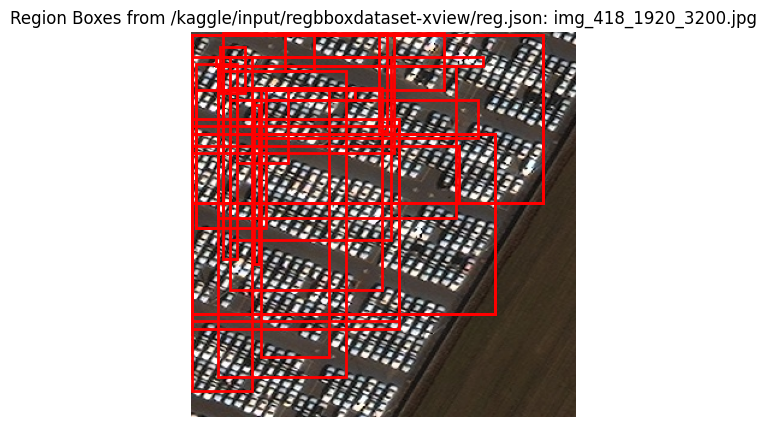

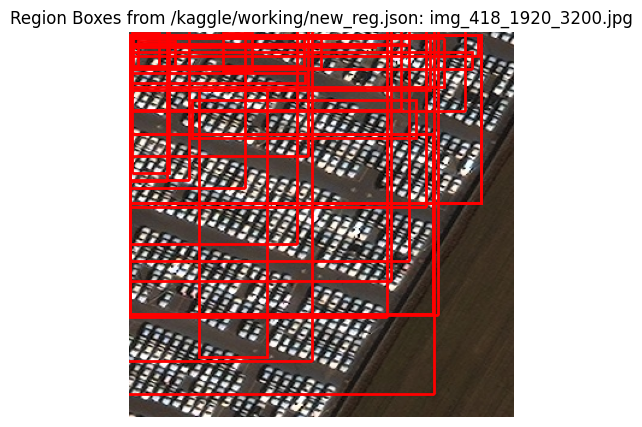

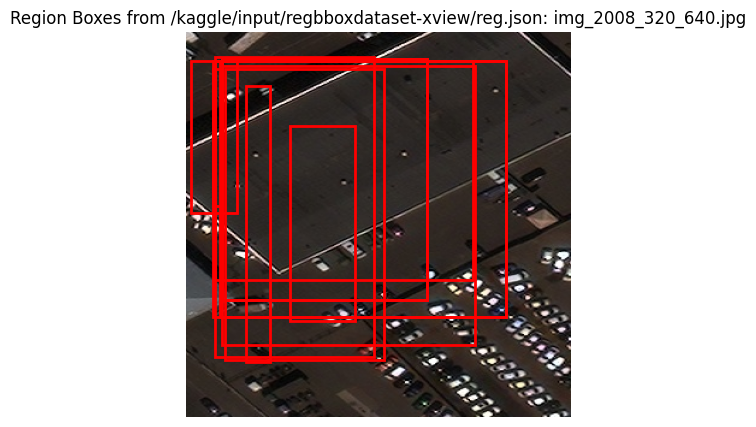

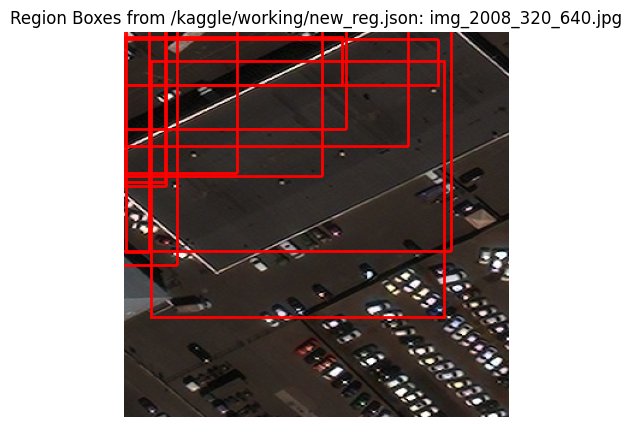

In [58]:
visualize_boxes(in_reg_path, out_reg_path, in_actproposals_json, img_fldr, selected_files=["img_418_1920_3200.jpg", "img_2008_320_640.jpg"])

In [44]:
def find_duplicate_image_ids(json_data):
    # Un dizionario per contare le occorrenze degli image_id
    image_id_count = defaultdict(list)

    # Itera attraverso i dati JSON e conta gli image_id
    for entry in json_data:
        image_id = entry['image_id']
        image_id_count[image_id].append(entry)

    # Filtra gli image_id che appaiono più di una volta
    duplicates = {image_id: details for image_id, details in image_id_count.items() if len(details) > 1}

    return duplicates

# Carica il file JSON
# Supponiamo che il file JSON sia chiamato "data.json" e contenga una lista di oggetti
with open(in_reg_path, 'r') as f:
    data = json.load(f)

# Chiamata alla funzione per trovare i duplicati
duplicates = find_duplicate_image_ids(data)

# Stampa i duplicati
if duplicates:
    print("Duplicati trovati:")
    for image_id, details in duplicates.items():
        print(f"Image ID: {image_id}")
        for detail in details:
            print(f"  Dettagli: {detail}")
else:
    print("Nessun duplicato trovato.")

Duplicati trovati:
Image ID: 165425602880
  Dettagli: {'image_id': 165425602880, 'file_name': 'image_026564.jpg', 'category_id': 6, 'proposal_id': 72, 'region_bbox': [76, 90, 280, 318], 'original_bbox': [], 'saved_path': '/kaggle/input/activeregion-xviewdataset/proposals/image_026564.jpg'}
  Dettagli: {'image_id': 165425602880, 'file_name': 'image_026562.jpg', 'category_id': 6, 'proposal_id': 12, 'region_bbox': [226, 102, 280, 178], 'original_bbox': [222.0, 128.0, 267.0, 171.0], 'saved_path': '/kaggle/input/activeregion-xviewdataset/proposals/image_026562.jpg'}
Image ID: 145919201600
  Dettagli: {'image_id': 145919201600, 'file_name': 'image_005076.jpg', 'category_id': 2, 'proposal_id': 15, 'region_bbox': [190, 74, 210, 110], 'original_bbox': [190.0, 66.0, 213.0, 113.0], 'saved_path': '/kaggle/input/activeregion-xviewdataset/proposals/image_005076.jpg'}
  Dettagli: {'image_id': 145919201600, 'file_name': 'image_005078.jpg', 'category_id': 2, 'proposal_id': 26, 'region_bbox': [8, 210, 3